<a href="https://colab.research.google.com/github/larsmoan/COMP3710/blob/main/assignement_2/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.6 MB/s eta 0:00:00
time: 249 µs (started: 2023-08-30 06:30:25 +00:00)


In [3]:
import torch
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

time: 5.45 s (started: 2023-08-30 06:30:25 +00:00)


In [4]:
#Getting the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #This is using arbitrary values for the mean and std which is wrong


batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:13<00:00, 12282844.06it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
time: 23.5 s (started: 2023-08-30 06:30:31 +00:00)


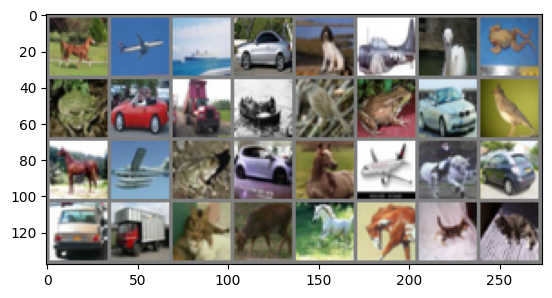

horse plane ship  car   dog   plane bird  frog  frog  car   truck ship  bird  frog  car   bird  horse plane frog  car   horse plane horse car   car   truck cat   deer  horse horse cat   cat  
time: 1 s (started: 2023-08-30 06:30:54 +00:00)


In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
import torch.nn as nn
class CIFAR10Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Add this line to calculate the flattened size
        self.flatten_size = self.calculate_flatten_size()

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def calculate_flatten_size(self):
        # Test with a dummy tensor to calculate the flattened size
        x = torch.zeros(1, 3, 32, 32)  # Assumes 32x32 input size
        x = self.network(x)
        return x.view(1, -1).shape[1]

    def forward(self, x):
        x = self.network(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.classifier(x)
        return x

num_classes = 10
model = CIFAR10Classifier(num_classes)
print(model)  # To check the architecture and flattened size

In [18]:
import torch.nn as nn
class CIFAR10Classifier(nn.Module):
  def calculate_flatten_size(self):
        # Test with a dummy tensor to calculate the flattened size
        x = torch.randn(1, 3, 32, 32)  # Assumes 32x32 input size
        x = self.network(x)
        return x.view(x.size(0), -1).shape[1]

  def __init__(self,num_classes):
    super().__init__()
    self.network = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
    )

    # Calculate the correct input size for the first linear layer
    self.flatten_size = self.calculate_flatten_size()

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(self.flatten_size, 1024),  # Adjusted to match the calculated size
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, num_classes)
    )

  def forward(self, x):
      x = self.network(x)
      x = x.view(x.size(0), -1)  # Flatten the output
      x = self.classifier(x)
      return x

# Create the model
num_classes = 10
model = CIFAR10Classifier(num_classes)
print(model)  # To check the architecture and flattened size

CIFAR10Classifier(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=1024, bias=True)
    (2): 

In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

time: 1.11 ms (started: 2023-08-30 06:38:02 +00:00)


In [20]:
num_epochs = 50

time: 443 µs (started: 2023-08-30 06:38:03 +00:00)


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CIFAR10Classifier(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=1024, bias=True)
    (2): 

time: 13.1 ms (started: 2023-08-30 06:38:04 +00:00)


In [22]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

Epoch 1/50, Loss: 1.6313568656443025
Epoch 2/50, Loss: 1.0840255818302937
Epoch 3/50, Loss: 0.8581599929511204
Epoch 4/50, Loss: 0.7137408287419925
Epoch 5/50, Loss: 0.605782657108548
Epoch 6/50, Loss: 0.5134966199596723
Epoch 7/50, Loss: 0.4282853102224497
Epoch 8/50, Loss: 0.36192546173648926
Epoch 9/50, Loss: 0.3008713761340977
Epoch 10/50, Loss: 0.2594955409056211
Epoch 11/50, Loss: 0.23222682181083176
Epoch 12/50, Loss: 0.21738706654985213
Epoch 13/50, Loss: 0.2038861311249964
Epoch 14/50, Loss: 0.18157115438982835
Epoch 15/50, Loss: 0.17439486586500105
Epoch 16/50, Loss: 0.16956475183951072
Epoch 17/50, Loss: 0.16649482040564748
Epoch 18/50, Loss: 0.15221043098016307
Epoch 19/50, Loss: 0.15648008017578494
Epoch 20/50, Loss: 0.14302610766285015
Epoch 21/50, Loss: 0.14853777299160364
Epoch 22/50, Loss: 0.14623011949815343
Epoch 23/50, Loss: 0.13944404953007747
Epoch 24/50, Loss: 0.1381072817528644
Epoch 25/50, Loss: 0.13757042171920233
Epoch 26/50, Loss: 0.13313225773464793
Epoch 2

In [23]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

time: 46.1 ms (started: 2023-08-30 06:57:10 +00:00)


In [24]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)

        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 73 %
time: 4.51 s (started: 2023-08-30 06:57:10 +00:00)
